# Linear Algebra ([docs](https://docs.julialang.org/en/v1.0.0/stdlib/LinearAlgebra/))

Since **quantum mechanics is linear algebra in disguise**, most quantum algorithms involve matrix operations.

After `using LinearAlgebra`, **Julia speaks linear algebra fluently**.

Performing linear algebra operations on a computer is, of course, an old problem. Lots of amazing libraries have been written - mostly in Fortran - which have been optimized over decades.

Basically all high-level programming languages use these libraries, including R, Python, and Julia.

Linear algebra in Julia is largely implemented by calling [BLAS](http://www.netlib.org/blas/)/[LAPACK](http://www.netlib.org/lapack/) functions. Sparse operations utilize functionality in [SuiteSparse](http://faculty.cse.tamu.edu/davis/suitesparse.html).

As per default, Julia uses the [OpenBLAS](https://github.com/xianyi/OpenBLAS) implementation (BLAS, LAPACK, LIBM), which can be replaced by [Intel's MKL](https://software.intel.com/en-us/mkl) (BLAS, LAPACK) and [Intel's Math Library](https://software.intel.com/en-us/node/522653) (LIBM).

**What is all this stuff?!?**

* **BLAS**: a collection of low-level matrix and vector arithmetic operations ("multiply two matrices", "multiply a matrix by vector").
* **LAPACK**:  a collection of higher-level linear algebra operations. Things like matrix factorizations (LU, LLt, QR, SVD, Schur, etc) that are used to do things like “find the eigenvalues of a matrix”, or “find the singular values of a matrix”, or “solve a linear system”.
* **LIBM**: basic math functions like `sin`, `cos`, `sinh`, etcetera

Sparse matrices are more difficult and there exist different collections of routines, one of which is **SuiteSparse**.

**Why do I have to care?**

* Switching from OpenBLAS to MKL can give you large speedups!
* Since you might be leaving the world of Julia code, you loose easy inspectability and type genericity. The latter can be an issue for machine learning, as we'll discuss later in more detail.

# Taking linear algebra seriously

Julia is [taking linear algebra seriously](https://www.youtube.com/watch?v=C2RO34b_oPM)! (see [here](https://github.com/JuliaLang/julia/issues/4774), and [here](https://github.com/JuliaLang/julia/issues/20978)).

In [1]:
using LinearAlgebra

In [2]:
A = rand(4,4)

4×4 Array{Float64,2}:
 0.0251479  0.569003  0.174507   0.25139 
 0.800646   0.920914  0.834187   0.238625
 0.165034   0.169273  0.906141   0.738086
 0.420825   0.903913  0.0823355  0.746347

In [3]:
typeof(A)

Array{Float64,2}

In [4]:
Array{Float64, 2} === Matrix{Float64} # equivalent not just equal

true

In [5]:
det(A)

-0.2803037572497358

In [6]:
inv(A)

4×4 Array{Float64,2}:
 -2.94635    0.864102  -0.322084   1.03466
  2.0029     0.157895  -0.511121  -0.21965
  0.862652   0.40186    0.665365  -1.07705
 -0.85962   -0.722782   0.727231   1.14131

In [7]:
rank(A)

4

Let's get a vector as well

In [8]:
v = rand(4)

4-element Array{Float64,1}:
 0.35970024321038463
 0.7935866200758142 
 0.08615588113823969
 0.47803743926608067

In [9]:
typeof(v)

Array{Float64,1}

In [10]:
Array{Float64,1} === Vector{Float64}

true

In [11]:
norm(v)

0.9975503083673237

In [12]:
v^2 # can't square a vector

MethodError: MethodError: no method matching ^(::Array{Float64,1}, ::Int64)
Closest candidates are:
  ^(!Matched::Float16, ::Integer) at math.jl:796
  ^(!Matched::Missing, ::Integer) at missing.jl:130
  ^(!Matched::Missing, ::Number) at missing.jl:94
  ...

In [13]:
v.^2

4-element Array{Float64,1}:
 0.12938426496560984 
 0.6297797235633545  
 0.007422835854706485
 0.22851979334007178 

Some things might be suprising

In [14]:
1/v

1×4 Transpose{Float64,Array{Float64,1}}:
 0.361469  0.797489  0.0865795  0.480388

But if it works, there is typically meaning to it. In this case it is calculating the [Moore-Penrose-Pseudoinverse](https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse#Vectors) (`transpose(v)/sum(abs2,v)`).

### Identity matrix: `UniformScaling` operator

In [15]:
A + 3

MethodError: MethodError: no method matching +(::Array{Float64,2}, ::Int64)
Closest candidates are:
  +(::Any, ::Any, !Matched::Any, !Matched::Any...) at operators.jl:529
  +(!Matched::Complex{Bool}, ::Real) at complex.jl:293
  +(!Matched::Missing, ::Number) at missing.jl:94
  ...

In [16]:
A .+ 3

4×4 Array{Float64,2}:
 3.02515  3.569    3.17451  3.25139
 3.80065  3.92091  3.83419  3.23862
 3.16503  3.16927  3.90614  3.73809
 3.42082  3.90391  3.08234  3.74635

The `UniformScaling` operator **represents an identity matrix of any size** and is another great example of **duck typing**. It automatically gets loaded into scope when you do `using LinearAlgebra` and has the name `I`.

In [18]:
I

UniformScaling{Bool}
true*I

Although it never actually materializes a full identity matrix it behaves like one.

In [19]:
A + 3I

4×4 Array{Float64,2}:
 3.02515   0.569003  0.174507   0.25139 
 0.800646  3.92091   0.834187   0.238625
 0.165034  0.169273  3.90614    0.738086
 0.420825  0.903913  0.0823355  3.74635 

In [20]:
I * A == A

true

Hence, we can calculate things like, say, `A-b*I` without ever allocating a dense identity matrix, which would take up $\mathcal{O}(n^2)$ memory.

Let's benchmark the performance difference!

In [22]:
fullI = Matrix{Float64}(I, 4,4) # alternatively but slower, diagm(ones(4))

4×4 Array{Float64,2}:
 1.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0
 0.0  0.0  1.0  0.0
 0.0  0.0  0.0  1.0

In [23]:
fast(A) = A + 3*I

fast (generic function with 1 method)

In [24]:
slow(A, fullI) = A + 3*fullI

slow (generic function with 1 method)

In [25]:
function slower(A)
    fullI = Matrix(1.0I, size(A)...)
    A + 3*fullI
end

slower (generic function with 1 method)

In [26]:
using BenchmarkTools
@btime fast($A);
@btime slow($A, $fullI);
@btime slower($A);

  34.372 ns (1 allocation: 208 bytes)
  106.760 ns (2 allocations: 416 bytes)
  144.055 ns (3 allocations: 624 bytes)


# Utilizing matrix factorizations

[Matrix factorizations (a.k.a. matrix decompositions)](https://en.wikipedia.org/wiki/Matrix_decomposition)
are factorization of a matrix into a product of matrices, and are one of the central concepts
in linear algebra.

Making good use of matrix factorizations is crucial for efficient linear algebra operations.

Example: Solving the linear system `Ax = b`.

In [27]:
A = rand(1:10, 5, 5)

5×5 Array{Int64,2}:
  8  8  1  10  1
  7  6  3  10  5
  2  8  3   3  9
  8  1  5   8  7
 10  2  4  10  3

In [28]:
b = rand(5)

5-element Array{Float64,1}:
 0.2728082758069206
 0.7632722900493893
 0.9227293283499092
 0.9989828973919723
 0.0866752583372008

Solve explicitly

In [29]:
inv(A)*b

5-element Array{Float64,1}:
  0.2047354867675181 
 -0.23475037959269082
 -1.0584778197366018 
  0.09857416428204521
  0.5856635953244522 

Solve by left division `\`

In [31]:
A\b

5-element Array{Float64,1}:
  0.2047354867675187 
 -0.23475037959269107
 -1.058477819736604  
  0.09857416428204503
  0.5856635953244533 

In [32]:
using BenchmarkTools
@btime inv($A)*$b; # it is (almost) never necessary to calculate the dense inverse
@btime $A\$b;

  990.000 ns (7 allocations: 3.50 KiB)
  304.449 ns (4 allocations: 576 bytes)


What does Julia do to make this so much faster?

It knows that it can perform the division much faster if it first [LU decomposes](https://en.wikipedia.org/wiki/LU_decomposition) `A`.

In [33]:
lu(A)\b

5-element Array{Float64,1}:
  0.2047354867675187 
 -0.23475037959269107
 -1.058477819736604  
  0.09857416428204503
  0.5856635953244533 

In [34]:
@btime lu($A)\$b

  293.680 ns (4 allocations: 576 bytes)


5-element Array{Float64,1}:
  0.2047354867675187 
 -0.23475037959269107
 -1.058477819736604  
  0.09857416428204503
  0.5856635953244533 

Let's inspect the output of `lu(A)`

In [35]:
lu(A)

LU{Float64,Array{Float64,2}}
L factor:
5×5 Array{Float64,2}:
 1.0     0.0   0.0       0.0      0.0
 0.875   1.0   0.0       0.0      0.0
 0.25   -6.0   1.0       0.0      0.0
 1.0     7.0  -0.701613  1.0      0.0
 1.25    8.0  -0.919355  1.00157  1.0
U factor:
5×5 Array{Float64,2}:
 8.0   8.0   1.0    10.0      1.0     
 0.0  -1.0   2.125   1.25     4.125   
 0.0   0.0  15.5     8.0     33.5     
 0.0   0.0   0.0    -5.1371   0.629032
 0.0   0.0   0.0     0.0     -1.08163 

In [36]:
typeof(lu(A))

LU{Float64,Array{Float64,2}}

In [37]:
supertype(LU)

Factorization

### List of factorizations

The following table summarizes the types of matrix factorizations that have been implemented in
Julia. Details of their associated methods can be found in the [Standard Functions](https://docs.julialang.org/en/latest/stdlib/LinearAlgebra/#Standard-Functions-1) section
of the Linear Algebra documentation.

| Type               | Description                                                                                                    |
|:------------------ |:-------------------------------------------------------------------------------------------------------------- |
| `BunchKaufman`     | Bunch-Kaufman factorization                                                                                    |
| `Cholesky`         | [Cholesky factorization](https://en.wikipedia.org/wiki/Cholesky_decomposition)                                 |
| `CholeskyPivoted`  | [Pivoted](https://en.wikipedia.org/wiki/Pivot_element) Cholesky factorization                                  |
| `LDLt`             | [LDL(T) factorization](https://en.wikipedia.org/wiki/Cholesky_decomposition#LDL_decomposition)                 |
| `LU`               | [LU factorization](https://en.wikipedia.org/wiki/LU_decomposition)                                             |
| `QR`               | [QR factorization](https://en.wikipedia.org/wiki/QR_decomposition)                                             |
| `QRCompactWY`      | Compact WY form of the QR factorization                                                                        |
| `QRPivoted`        | Pivoted [QR factorization](https://en.wikipedia.org/wiki/QR_decomposition)                                     |
| `LQ`               | [QR factorization](https://en.wikipedia.org/wiki/QR_decomposition) of `transpose(A)`                           |
| `Hessenberg`       | [Hessenberg decomposition](http://mathworld.wolfram.com/HessenbergDecomposition.html)                          |
| `Eigen`            | [Spectral decomposition](https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix)                         |
| `GeneralizedEigen` | [Generalized spectral decomposition](https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix#Generalized_eigenvalue_problem)                            |
| `SVD`              | [Singular value decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition)                     |
| `GeneralizedSVD`   | [Generalized SVD](https://en.wikipedia.org/wiki/Generalized_singular_value_decomposition#Higher_order_version) |
| `Schur`            | [Schur decomposition](https://en.wikipedia.org/wiki/Schur_decomposition)                                       |
| `GeneralizedSchur` | [Generalized Schur decomposition](https://en.wikipedia.org/wiki/Schur_decomposition#Generalized_Schur_decomposition) |

(Taken from the Julia docs)

In [38]:
@btime lu($A)\$b
@btime qr($A)\$b
@btime svd($A)\$b;

  294.834 ns (4 allocations: 576 bytes)
  4.314 μs (9 allocations: 1.48 KiB)
  8.566 μs (18 allocations: 4.91 KiB)


From the documentation (`?\`) of the left division operator:

>Matrix division using a polyalgorithm. For input matrices A and B, the result X is such that A*X == B when A is square. The solver that is used depends upon the structure of A. If A is upper or lower triangular (or diagonal), no factorization of A is required and the system is solved with either forward or backward substitution.

This is what the actual heuristic looks like (`@which`/`@edit` are your friends!)

```julia
function (\)(A::AbstractMatrix, B::AbstractVecOrMat)
    @assert !has_offset_axes(A, B)
    m, n = size(A)
    if m == n
        if istril(A)
            if istriu(A)
                return Diagonal(A) \ B
            else
                return LowerTriangular(A) \ B
            end
        end
        if istriu(A)
            return UpperTriangular(A) \ B
        end
        return lu(A) \ B
    end
    return qr(A,Val(true)) \ B
end
```

Generically, a heuristic is implemented in `factorize`:

In [39]:
typeof(factorize(A))

LU{Float64,Array{Float64,2}}

In [40]:
typeof(factorize(A+A'))

BunchKaufman{Float64,Array{Float64,2}}

# Fast linear algebra with multiple dispatch

Ok, we've seen that Julia analyses the input matrix using some heuristic, factorizes it appropriately to then perform the calculation efficiently. 

But we can (and probably should) also be more explicit about our input to avoid this heuristic. We can encode the special structure of our matrix in a type such that we directly dispatch to the efficient method. Remember, the types decide which method is actually being run!

There are many reasons to indicate what kind of matrix we have.

* Don't rely on a heuristic. Not all methods have one!
* The heurisitc comes with a small performance penalty.
* The heurisitc isn't perfect and might fail to notice our matrix's special structure. Maybe because it's not known to base Julia. As we'll see later on, many external packages define additional special matrix types and efficient procedures for them.

The following special matrix types are available out-of-the-box.

### Standard matrix types

>[Matrices with special symmetries and structures](http://www2.imm.dtu.dk/pubdb/views/publication_details.php?id=3274)
arise often in linear algebra and are frequently associated with various matrix factorizations.
Julia features a rich collection of special matrix types, which allow for fast computation with
specialized routines that are specially developed for particular matrix types.
>
>The following tables summarize the types of special matrices that have been implemented in Julia,
as well as whether hooks to various optimized methods for them in LAPACK are available.

| Type                          | Description                                                                                   |
|:----------------------------- |:--------------------------------------------------------------------------------------------- |
| [`Symmetric`](@ref)           | [Symmetric matrix](https://en.wikipedia.org/wiki/Symmetric_matrix)                            |
| [`Hermitian`](@ref)           | [Hermitian matrix](https://en.wikipedia.org/wiki/Hermitian_matrix)                            |
| [`UpperTriangular`](@ref)     | Upper [triangular matrix](https://en.wikipedia.org/wiki/Triangular_matrix)                    |
| [`UnitUpperTriangular`](@ref) | Upper [triangular matrix](https://en.wikipedia.org/wiki/Triangular_matrix) with unit diagonal |
| [`LowerTriangular`](@ref)     | Lower [triangular matrix](https://en.wikipedia.org/wiki/Triangular_matrix)                    |     |
| [`UnitLowerTriangular`](@ref) | Lower [triangular matrix](https://en.wikipedia.org/wiki/Triangular_matrix) with unit diagonal |
| [`UpperHessenberg`](@ref)     | Upper [Hessenberg matrix](https://en.wikipedia.org/wiki/Hessenberg_matrix)
| [`Tridiagonal`](@ref)         | [Tridiagonal matrix](https://en.wikipedia.org/wiki/Tridiagonal_matrix)                        |
| [`SymTridiagonal`](@ref)      | Symmetric tridiagonal matrix                                                                  |
| [`Bidiagonal`](@ref)          | Upper/lower [bidiagonal matrix](https://en.wikipedia.org/wiki/Bidiagonal_matrix)              |
| [`Diagonal`](@ref)            | [Diagonal matrix](https://en.wikipedia.org/wiki/Diagonal_matrix)                              |
| [`UniformScaling`](@ref)      | [Uniform scaling operator](https://en.wikipedia.org/wiki/Uniform_scaling)                     |

(Taken from the Julia docs)

In [41]:
D = Diagonal(1:5)

5×5 Diagonal{Int64,UnitRange{Int64}}:
 1  ⋅  ⋅  ⋅  ⋅
 ⋅  2  ⋅  ⋅  ⋅
 ⋅  ⋅  3  ⋅  ⋅
 ⋅  ⋅  ⋅  4  ⋅
 ⋅  ⋅  ⋅  ⋅  5

In [42]:
Ddense = Matrix(D) # same matrix but type doesn't indicate diagonal structure

5×5 Array{Int64,2}:
 1  0  0  0  0
 0  2  0  0  0
 0  0  3  0  0
 0  0  0  4  0
 0  0  0  0  5

In [43]:
@btime $D*$b
@btime $Ddense*$b

  32.192 ns (1 allocation: 128 bytes)
  53.908 ns (1 allocation: 128 bytes)


5-element Array{Float64,1}:
 0.2728082758069206
 1.5265445800987787
 2.7681879850497273
 3.9959315895678893
 0.433376291686004 

What method does it dispatch to?

In [44]:
@which D*b

*(D::Diagonal, V::AbstractArray{T,1} where T) in LinearAlgebra at C:\cygwin\home\Administrator\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.2\LinearAlgebra\src\diagonal.jl:163

In [45]:
@which Ddense*b

*(A::AbstractArray{T,2}, x::AbstractArray{S,1}) where {T, S} in LinearAlgebra at C:\cygwin\home\Administrator\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.2\LinearAlgebra\src\matmul.jl:50

**Dense Diagonal** (`Ddense*b`)

```julia
function (*)(A::AbstractMatrix{T}, x::AbstractVector{S}) where {T,S}
    TS = promote_op(matprod, T, S)
    mul!(similar(x,TS,axes(A,1)),A,x)
end
```

**Diagonal** (`D*b`)
```julia
(*)(D::Diagonal, V::AbstractVector) = D.diag .* V
```

# Fermions hopping on a chain

$$\mathcal{H} = -t\sum_{\langle i,j \rangle} c_i^\dagger c_j + \mu \sum_i n_i$$

Here, $t$ is the hopping amplitude, $\mu$ is the chemical potential, and $c, c^\dagger$ are creation and annihilation operators.

For simplicity, we'll consider **open boundary conditions** (not periodic), in which case the Hamiltonian is tridiagonal.

Since the fermions are *not* interacting, we can work in the *single particle basis* and do not have to worry about how to construct a basis for the many-body Fock space.

We use the canonical cartesian basis in which one uses $0$s to indicate empty sites and a $1$ for the particle's site, i.e. $|00100\rangle$ represents the basis state which has the particle exclusively on the 3rd site.

If you aren't familiar with second quantization just think of $\mathcal{H}$ as any quantum mechanical operator that can be represented as a matrix.

In [46]:
N = 100 # number of sites
t = 1
μ = -0.5

H = diagm(0 => fill(μ, N), 1 => fill(-t, N-1), -1 => fill(-t, N-1))

100×100 Array{Float64,2}:
 -0.5  -1.0   0.0   0.0   0.0   0.0  …   0.0   0.0   0.0   0.0   0.0   0.0
 -1.0  -0.5  -1.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0  -1.0  -0.5  -1.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0  -1.0  -0.5  -1.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0  -1.0  -0.5  -1.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0  -1.0  -0.5  …   0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0  -1.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0  …   0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0

In [47]:
ψ = normalize(rand(N)); # some state

In [48]:
ev(H, ψ) = ψ'*H*ψ # <φ|H|φ>

ev (generic function with 1 method)

In [49]:
ev(H, ψ)

-1.9934291341886468

In [50]:
@btime ev($H, $ψ);

  11.000 μs (1 allocation: 896 bytes)


In [51]:
typeof(H)

Array{Float64,2}

As long as the code is generic (respects the informal `AbstractArray` interface), we can use the same piece of code for completely different array types.

Let's utilize the sparsity of `H` by indicating it through a type.

In [52]:
using SparseArrays
Hsparse = sparse(H)

100×100 SparseMatrixCSC{Float64,Int64} with 298 stored entries:
  [1  ,   1]  =  -0.5
  [2  ,   1]  =  -1.0
  [1  ,   2]  =  -1.0
  [2  ,   2]  =  -0.5
  [3  ,   2]  =  -1.0
  [2  ,   3]  =  -1.0
  [3  ,   3]  =  -0.5
  [4  ,   3]  =  -1.0
  [3  ,   4]  =  -1.0
  [4  ,   4]  =  -0.5
  [5  ,   4]  =  -1.0
  [4  ,   5]  =  -1.0
  ⋮
  [96 ,  96]  =  -0.5
  [97 ,  96]  =  -1.0
  [96 ,  97]  =  -1.0
  [97 ,  97]  =  -0.5
  [98 ,  97]  =  -1.0
  [97 ,  98]  =  -1.0
  [98 ,  98]  =  -0.5
  [99 ,  98]  =  -1.0
  [98 ,  99]  =  -1.0
  [99 ,  99]  =  -0.5
  [100,  99]  =  -1.0
  [99 , 100]  =  -1.0
  [100, 100]  =  -0.5

In [53]:
@btime ev($Hsparse, $ψ);

  337.268 ns (2 allocations: 912 bytes)


That's a solid **30x speedup**!

Our `H` isn't just sparse, but actually tridiagonal. Let's try to exploit that.

In [54]:
Htri = Tridiagonal(H)

100×100 Tridiagonal{Float64,Array{Float64,1}}:
 -0.5  -1.0    ⋅     ⋅     ⋅     ⋅   …    ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
 -1.0  -0.5  -1.0    ⋅     ⋅     ⋅        ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅   -1.0  -0.5  -1.0    ⋅     ⋅        ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅   -1.0  -0.5  -1.0    ⋅        ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅   -1.0  -0.5  -1.0       ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅   -1.0  -0.5  …    ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅   -1.0       ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅        ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅        ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅        ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅   …    ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅        ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅        ⋅     ⋅    

In [55]:
@btime ev($Htri, $ψ);

  168.365 ns (4 allocations: 976 bytes)


Choosing the best type (and therewith an algorithm) can be tricky and one has to play around a bit. The good thing is that it's very easy to try out different types!

Note that there are also great matrix types available in the ecosystem, see [JuliaMatrices](https://github.com/JuliaMatrices), for example.

# Exact diagonalisation a.k.a Eigendecomposition

To diagonalize our dense "Hamiltonian", we simply call the built-in function `eigen`.

In [56]:
vals, vecs = eigen(H)

Eigen{Float64,Float64,Array{Float64,2},Array{Float64,1}}
eigenvalues:
100-element Array{Float64,1}:
 -2.4990325645839753
 -2.4961311942671887
 -2.4912986959380365
 -2.484539744726553 
 -2.475860879481513 
 -2.4652704964445267
 -2.4527788411272136
 -2.438397998399332 
 -2.422141880797449 
 -2.4040262150654583
 -2.384068526939977 
 -2.3622881241953175
 -2.3387060779644715
  ⋮                 
  1.362288124195319 
  1.3840685269399784
  1.4040262150654599
  1.422141880797449 
  1.4383979983993322
  1.452778841127214 
  1.4652704964445273
  1.4758608794815133
  1.484539744726553 
  1.4912986959380372
  1.4961311942671887
  1.4990325645839762
eigenvectors:
100×100 Array{Float64,2}:
 0.00437636  -0.00874848  0.0131121  -0.0174631  …   0.00874848  -0.00437636
 0.00874848  -0.0174631   0.0261102  -0.0346562     -0.0174631    0.00874848
 0.0131121   -0.0261102   0.038881   -0.0513136      0.0261102   -0.0131121 
 0.0174631   -0.0346562   0.0513136  -0.0671776     -0.0346562    0.0174631 
 0.021

In [57]:
ψ0 = vecs[:,1] # single-particle groundstate

100-element Array{Float64,1}:
 0.004376357346900525 
 0.008748480850710498 
 0.013112140764309128 
 0.017463115528552488 
 0.02179719585635938  
 0.026110188804924692 
 0.030397921832121047 
 0.03465624683316357  
 0.03888104415363324  
 0.04306822657497679  
 0.04721374326862623  
 0.05131358371491453  
 0.055363781582994064 
 ⋮                    
 0.05131358371495845  
 0.04721374326866721  
 0.04306822657501444  
 0.03888104415366729  
 0.03465624683319377  
 0.03039792183214743  
 0.026110188804947167 
 0.02179719585637802  
 0.017463115528567313 
 0.013112140764320258 
 0.008748480850717935 
 0.0043763573469042276

In [58]:
ev(H, ψ0)

-2.4990325645839753

In [59]:
ev(H, ψ0) <= ev(H, ψ) # groundstate has the lowest energy

true

┌ Info: Recompiling stale cache file C:\Users\carsten\.julia\compiled\v1.2\Plots\ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1240


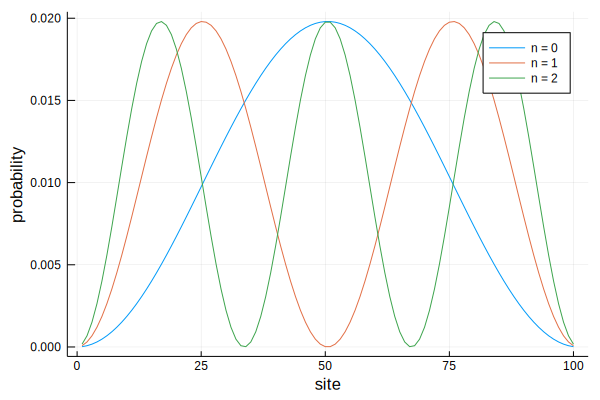

In [60]:
using Plots

show_n_states = 3

p = plot()
for i in 1:show_n_states
    plot!(p, abs2.(vecs[:,i]), xlab="site", ylab="probability", lab="n = $(i-1)")
end
p

In [ ]:
# Periodic boundary conditions
# T = copy(H)
# T[1,end] = -t
# T[end,1] = -t
# vals, vecs = eigen(T)

Since Julia is using eigenproblem solvers from LAPACK (written in a low-level language) the code is, of course, **not generic**.

The best Julia can do, without implementing new functionality, is manually dispatch to the best LAPACK routine available.

Hence, it won't work with most of our special matrices.

In [61]:
eigen(Htri);

MethodError: MethodError: no method matching eigen(::Tridiagonal{Float64,Array{Float64,1}})
Closest candidates are:
  eigen(::AbstractArray{TA,2}, !Matched::AbstractArray{TB,2}; kws...) where {TA, TB} at C:\cygwin\home\Administrator\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.2\LinearAlgebra\src\eigen.jl:402
  eigen(!Matched::SymTridiagonal{T,V} where V<:AbstractArray{T,1}) where T at C:\cygwin\home\Administrator\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.2\LinearAlgebra\src\tridiag.jl:201
  eigen(!Matched::SymTridiagonal{T,V} where V<:AbstractArray{T,1}, !Matched::UnitRange) where T at C:\cygwin\home\Administrator\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.2\LinearAlgebra\src\tridiag.jl:205
  ...

If we're lucky, someone has implemented a generic solver in Julia that works for a wider range of types. Example:

In [62]:
Hbig = big.(H)
Hh = Hermitian(Hbig)

100×100 Hermitian{BigFloat,Array{BigFloat,2}}:
 -0.50  -1.0    0.0    0.0    0.0   …   0.0    0.0    0.0    0.0    0.0 
 -1.0   -0.50  -1.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0 
  0.0   -1.0   -0.50  -1.0    0.0       0.0    0.0    0.0    0.0    0.0 
  0.0    0.0   -1.0   -0.50  -1.0       0.0    0.0    0.0    0.0    0.0 
  0.0    0.0    0.0   -1.0   -0.50      0.0    0.0    0.0    0.0    0.0 
  0.0    0.0    0.0    0.0   -1.0   …   0.0    0.0    0.0    0.0    0.0 
  0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0 
  0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0 
  0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0 
  0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0 
  0.0    0.0    0.0    0.0    0.0   …   0.0    0.0    0.0    0.0    0.0 
  0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0 
  0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0 
  ⋮ 

In [63]:
eigen(Hh);

MethodError: MethodError: no method matching eigen!(::Hermitian{BigFloat,Array{BigFloat,2}}; sortby=nothing)
Closest candidates are:
  eigen!(!Matched::SymTridiagonal{#s617,V} where V<:AbstractArray{#s617,1} where #s617<:Union{Float32, Float64}) at C:\cygwin\home\Administrator\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.2\LinearAlgebra\src\tridiag.jl:200 got unsupported keyword argument "sortby"
  eigen!(!Matched::SymTridiagonal{#s617,V} where V<:AbstractArray{#s617,1} where #s617<:Union{Float32, Float64}, !Matched::UnitRange) at C:\cygwin\home\Administrator\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.2\LinearAlgebra\src\tridiag.jl:203 got unsupported keyword argument "sortby"
  eigen!(!Matched::SymTridiagonal{#s617,V} where V<:AbstractArray{#s617,1} where #s617<:Union{Float32, Float64}, !Matched::Real, !Matched::Real) at C:\cygwin\home\Administrator\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.2\LinearAlgebra\src\tridiag.jl:208 got unsupported keyword argument "sortby"
  ...

In [64]:
using GenericLinearAlgebra

In [66]:
eigen(Hermitian(Hbig))

Eigen{BigFloat,BigFloat,Array{BigFloat,2},Array{BigFloat,1}}
eigenvalues:
100-element Array{BigFloat,1}:
 -2.499032564583976129841491078128552885270844564275068999255406464586997523509518
 -2.49613119426718869664469376721353683820035347873096011215866399535318914672511 
 -2.491298695938037160967995737868198811244191747682578616800626006817236297244357
 -2.484539744726553020184742526239320873977567777619982918612582442507556211531338
 -2.475860879481513441495886953659483104715504453725995724740209546532748607545501
 -2.465270496444527374874063414521910296283215789940930200782648270857681647241034
 -2.452778841127214059072142159451675184893454442233729896962151556967994660818164
 -2.438397998399332225887590822597361140711942686757388384968109952867283314193059
 -2.42214188079744909752949054940206867831399022597374035085438522526236180426978 
 -2.404026215065459784760611736625730055990725724610455570939344743892098437920844
 -2.3840685269399782640300730158834940759335207513742804317451818

Arguably the most important matrix type in physics applications is a sparse matrix, i.e. `SparseMatrixCSC`.

In [67]:
eigen(Hsparse)

ErrorException: eigen(A) not supported for sparse matrices. Use for example eigs(A) from the Arpack package instead.

Let's follow Julia's advice and take a look at [ARPACK.jl](https://github.com/JuliaLinearAlgebra/Arpack.jl).

### Diagonalizing sparse matrices

[ARPACK.jl]() -  Wrapper to Fortran library [ARPACK](https://www.caam.rice.edu/software/ARPACK/) which implements **iterative** eigenvalue and singular value solvers. By far the most established sparse eigensolver.

Julia implementations:

* [ArnoldiMethod.jl](https://github.com/haampie/ArnoldiMethod.jl)
* [KrylovKit.jl](https://github.com/Jutho/KrylovKit.jl)
* [IterativeSolvers.jl](https://github.com/JuliaMath/IterativeSolvers.jl)
* and more


A key thing to remember is that while `eigen` is - up to numerical errors - exact, the methods in the packages above are iterative and approximative.

Arpack uses a different name for the eigenvalue decomposition. They called it `eigs`.

In [70]:
size(Hsparse)

(100, 100)

In [68]:
using Arpack
λ, evs = eigs(Hsparse)

([-2.499032564583997, -2.4961311942671984, -2.491298695938046, -2.484539744726571, -2.4758608794815182, -2.4652704964445267], [-0.004376357346883243 0.00874848085072538 … -0.021797195856378005 -0.02611018880493217; -0.00874848085067608 0.017463115528582138 … -0.043068226575014114 -0.051313583714929265; … ; -0.008748480850739497 -0.017463115528548085 … -0.04306822657496766 0.0513135837149229; -0.004376357346915045 -0.008748480850708366 … -0.021797195856354735 0.026110188804928897], 6, 25, 334, [0.10152886694803813, -0.3073173836518221, -0.13808168248217428, 0.02192795334416142, 0.08647811793848889, -0.023839764809459305, 0.10424291749528851, -0.018245300549338504, -0.010734746198225974, 0.04966409679171471  …  -0.07942884899857107, -0.005011337046649324, 0.02345032480075343, 0.06206826648086016, -0.030976724739930385, 0.062544374665659, -0.0054016722352645125, -0.017326588567613387, -0.22047925445574962, 0.0829956537678384])

In [69]:
λ

6-element Array{Float64,1}:
 -2.499032564583997 
 -2.4961311942671984
 -2.491298695938046 
 -2.484539744726571 
 -2.4758608794815182
 -2.4652704964445267

For ArnoldiMethod, one has to go through a two-step process.

In [71]:
using ArnoldiMethod
decomp, history = partialschur(Hsparse)
λ, evs = partialeigen(decomp);

In [72]:
λ

6-element Array{Float64,1}:
 -2.499032564583973 
 -2.496131194267173 
 -2.4912986959380383
 -2.484539744726562 
 -2.475860879481497 
 -2.4652704964445347

In KrylovKit, they call the function `eigsolve`.

In [73]:
using KrylovKit
λ, evs = eigsolve(Hsparse);

In [74]:
λ

1-element Array{Float64,1}:
 -2.4990325645839766

# Core messages of this Notebook

* The standard libraries `LinearAlgebra` and `SparseArrays` make Julia speak linear algebra.
* **Indicate properties and structure of a matrix**, like hermiticity or sparsity, through types. Fallback to generic types only if you run into method errors.
* For **sparse matrix exact diagonalization**, ARPACK.jl is sort of a standard but there are great alternatives like ArnoldiMethods.jl.

# If time permits: Dude, I have a GPU!

To make another case for *generic programming*, if you want to move the calculation to a GPU, chances are you only have to change the type of your matrix!

Of course, this is only true if you have one :)

```julia
using CuArrays, BenchmarkTools

A, B = rand(1000,1000), rand(1000,1000);
Agpu, Bgpu = CuArray(A), CuArray(B);
println("A*B (cpu)")
@btime A*B;
# 9.702 ms (2 allocations: 7.63 MiB)

println("A*B (gpu)")
@btime Agpu*Bgpu
# 12.747 μs (19 allocations: 592 bytes)
```